# ZFundPredictor (ver. 1.2) Demo
## Selection Criteria:
* <font size=3><I>Subject</I></font> — Open-end equity funds or hybrid funds with at least 75% of the investment in stocks.
* <font size=3><I>Investment Style</I></font> — mid-/large-cap growth stocks.
* <font size=3><I>Period</I></font> — lauched before 2015.
* <font size=3><I>Asset Size</I></font> — at least 200 million Yuan.

## Benchmark
* <font size=3><I>Equity</I></font> — SSE Composite Index (000001:SH)

In [22]:
import math
from datetime import datetime, timedelta, date
import re
import pymysql
import yfinance as yf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")

from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
from eastm.spiders.em import EmSpider
em = EmSpider()
em.start_requests()

ModuleNotFoundError: No module named 'eastm.spiders.em'

In [ ]:
import os 
os.chdir('./')

from ZFundPredictor import FundPredictor
from ZFundETL import FundETL

ETL = FundETL()

## Getting data from MySQL

In [ ]:
ETL.sql_queries()
ETL.funds_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673199 entries, 0 to 673198
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   fticker   673199 non-null  object 
 1   hdate     673199 non-null  object 
 2   accu_nav  670637 non-null  float64
dtypes: float64(1), object(2)
memory usage: 15.4+ MB


In [ ]:
ETL.st_invariants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fticker             518 non-null    object 
 1   ftype               518 non-null    object 
 2   current_style       518 non-null    object 
 3   current_net_assets  518 non-null    float64
 4   current_stocks      518 non-null    float64
 5   current_bonds       278 non-null    float64
 6   current_cash        518 non-null    float64
 7   industry_1          507 non-null    object 
 8   industry_1_pct      507 non-null    float64
 9   industry_2          507 non-null    object 
 10  industry_2_pct      507 non-null    float64
 11  industry_3          507 non-null    object 
 12  industry_3_pct      507 non-null    float64
 13  industry_4          507 non-null    object 
 14  industry_4_pct      506 non-null    float64
 15  industry_5          507 non-null    object 
 16  industry

## Downloading data of index

In [31]:
from ZFundETL import FundETL

ETL = FundETL()
sindex = ETL.get_index()
sindex

AttributeError: 'FundETL' object has no attribute 'funds_sql'

## EDA - Preprocessing

Number of funds with missing values in *Historical Prices*: 4
Number of funds with missing values in *Short-Term Invariant Variables*: 11
Total number of funds to be dropped because of missing data: 15


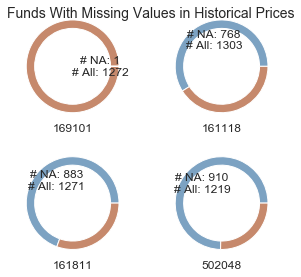

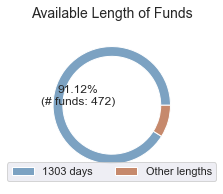

selected_tickers[0]: 000011
Number of selected tickers: 463


In [ ]:
selected_tickers = ETL.ticker_filter()

print('selected_tickers[0]:', selected_tickers[0])
print('Number of selected tickers:', len(selected_tickers))

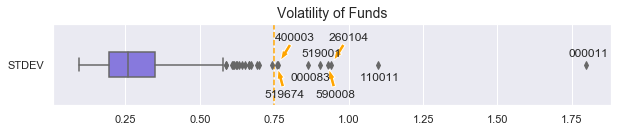

Removing funds with excessive volatility: ['000011', '000083', '110011', '260104', '400003', '519001', '519674', '590008']
Dates further dropped: ['2015-01-05', '2016-12-31', '2017-12-31', '2018-06-30', '2018-12-31', '2019-06-30']
Final available funds: 455
Final available days: 1297


,000020,000021,000031,000039,000042,000059,000061,000073,000082,000117,...,660015,671010,690001,690005,690007,690011,700001,710001,710002,sindex_r
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-24,2.921,3.094,2.243,2.3395,1.7704,1.6822,0.791,1.602,2.070,2.076,...,3.7360,0.928,2.503,2.364,3.284,1.799,1.691,2.3952,2.9182,-1.055839
2020-04-27,2.936,3.104,2.268,2.3389,1.7765,1.6881,0.787,1.627,2.078,2.092,...,3.7664,0.930,2.523,2.392,3.308,1.803,1.699,2.4024,2.9382,0.248032
2020-04-28,2.962,3.123,2.305,2.3564,1.7727,1.6840,0.778,1.651,2.087,2.125,...,3.8260,0.928,2.540,2.415,3.335,1.802,1.716,2.4142,2.9632,-0.194324
2020-04-29,2.972,3.122,2.318,2.3769,1.7770,1.6714,0.779,1.639,2.095,2.119,...,3.7963,0.931,2.519,2.398,3.295,1.804,1.701,2.3936,2.9647,0.441917
2020-04-30,3.024,3.171,2.407,2.4271,1.7924,1.6623,0.800,1.662,2.110,2.131,...,3.8491,0.946,2.529,2.403,3.298,1.828,1.707,2.3818,2.9968,1.333602


In [ ]:
funds = ETL.get_funds(selected_tickers, sindex['sindex_r'])
funds.tail()

In [ ]:
categorical = ETL.build_categories()
categorical.head()

,fund_type,fund_style,asset_size,ranking_score,current_stocks,current_bonds,current_cash,ind_0,ind_1,ind_2,...,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
fticker,,,,,,,,,,,,,,,,,,,,,
000020,混合型,大盘成长,"(9.03, 19.83]","(0.75, 1.0]",0.7859,0.0000,0.2472,0.4203,0.0788,0.0779,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0
000021,混合型,大盘成长,"(19.83, 186.94]","(0.0, 0.25]",0.8318,0.0341,0.1199,0.5522,0.0152,0.1850,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0
000031,混合型,大盘成长,"(19.83, 186.94]","(0.75, 1.0]",0.7869,0.0381,0.1774,0.5314,0.0000,0.1600,...,0.0,0.0424,0.0,0.0323,0.0,0.0,0.0000,0.0,0.0,0.0
000039,混合型,大盘平衡,"(2.009, 4.665]","(0.5, 0.75]",0.8121,0.0000,0.1759,0.3328,0.0000,0.4307,...,0.0,0.0000,0.0,0.0486,0.0,0.0,0.0000,0.0,0.0,0.0
000042,股票指数,大盘价值,"(2.009, 4.665]","(0.5, 0.75]",0.9254,0.0000,0.0756,0.4090,0.1954,0.0000,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0674,0.0,0.0,0.0


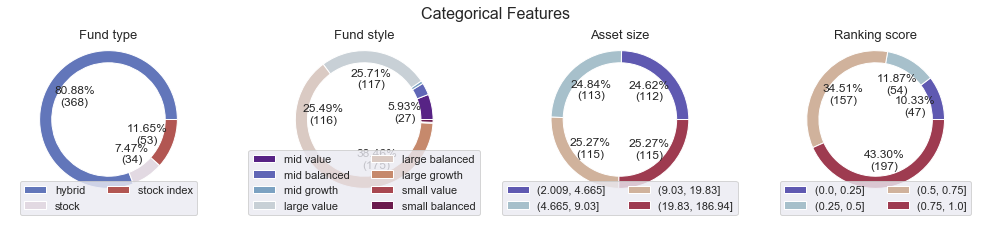

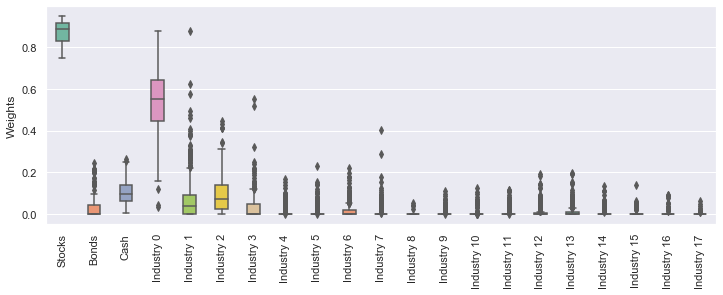

,ind_0,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
行业,制造业,金融业,信息传输、软件和信息技术服务业,房地产业,交通运输、仓储和邮政业,农、林、牧、渔业,批发和零售业,采矿业,住宿和餐饮业,租赁和商务服务业,水利、环境和公共设施管理业,文化、体育和娱乐业,科学研究和技术服务业,卫生和社会工作,建筑业,电力、热力、燃气及水生产和供应业,教育,综合
Industry,Manufacturing,Finance,"Information Transmission, Software & Informati...",Real Estate,"Transportation, Warehousing & Postal Services","Agriculture, Forestry, Animal Husbandry & Fishery",Wholesale & Retail Trade,Mining,Hospitality & Catering,Lease & Business Services,"Water Conservancy, Environment & Public Facili...","Culture, Sports & Entertainment",Scientific Research & Technical Services,Health & Social Work,Construction,"Power, Heat, Gas & Water Production and Supply",Education,Comprehensive
mean,0.5438,0.0727,0.0931,0.0337,0.0092,0.0095,0.0156,0.0087,0.0003,0.0048,0.0027,0.0079,0.0113,0.0131,0.0044,0.0019,0.002,0.0006
std,0.138,0.1096,0.0891,0.0576,0.0235,0.0257,0.0332,0.0313,0.0038,0.0145,0.0132,0.02,0.0258,0.0291,0.0159,0.0102,0.0107,0.0046
min,0.0316,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,0.4474,0,0.0233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,0.5518,0.0377,0.0727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75%,0.6433,0.0895,0.1409,0.0479,0,0,0.0205,0,0,0,0,0,0.0044,0.0112,0,0,0,0
max,0.8789,0.8807,0.4443,0.5531,0.166,0.2299,0.2198,0.4012,0.0525,0.1115,0.1222,0.1138,0.1924,0.1956,0.1328,0.1365,0.0905,0.0622


In [ ]:
ETL.categorical_summary()

## Read in or Save Preprocessed Datasets

In [ ]:
# funds, categorical = ETL.read_files('./', '20200430')

ETL.save_files('./')

## FundPredictor

In [38]:
import csv
from pandas.core.frame import DataFrame
import pandas as pd
 
# tmp_lst = []
# with open('demo/funds_20200430.csv', 'r') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         tmp_lst.append(row)
# df = pd.DataFrame(tmp_lst[1:], columns=tmp_lst[0],index=False)

df = pd.read_csv('demo/funds_20200430.csv', index_col=0)
print(df)

            000020  000021  000031  000039  000042  000059  000061  000073  \
Date                                                                         
2015-01-06   1.271   2.581   1.648  1.4078  1.4640  1.2090   0.946   1.008   
2015-01-07   1.274   2.580   1.638  1.4045  1.4670  1.2000   0.937   1.005   
2015-01-08   1.276   2.569   1.613  1.3802  1.4340  1.2010   0.934   1.000   
2015-01-09   1.280   2.570   1.607  1.3834  1.4300  1.1990   0.927   1.005   
2015-01-12   1.274   2.575   1.607  1.3760  1.4100  1.1970   0.918   1.022   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2020-04-24   2.921   3.094   2.243  2.3395  1.7704  1.6822   0.791   1.602   
2020-04-27   2.936   3.104   2.268  2.3389  1.7765  1.6881   0.787   1.627   
2020-04-28   2.962   3.123   2.305  2.3564  1.7727  1.6840   0.778   1.651   
2020-04-29   2.972   3.122   2.318  2.3769  1.7770  1.6714   0.779   1.639   
2020-04-30   3.024   3.171   2.407  2.4271  1.7924  1.6623   0.8

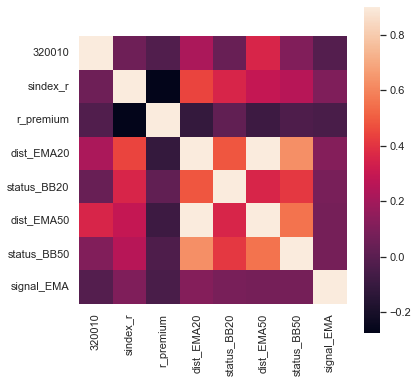

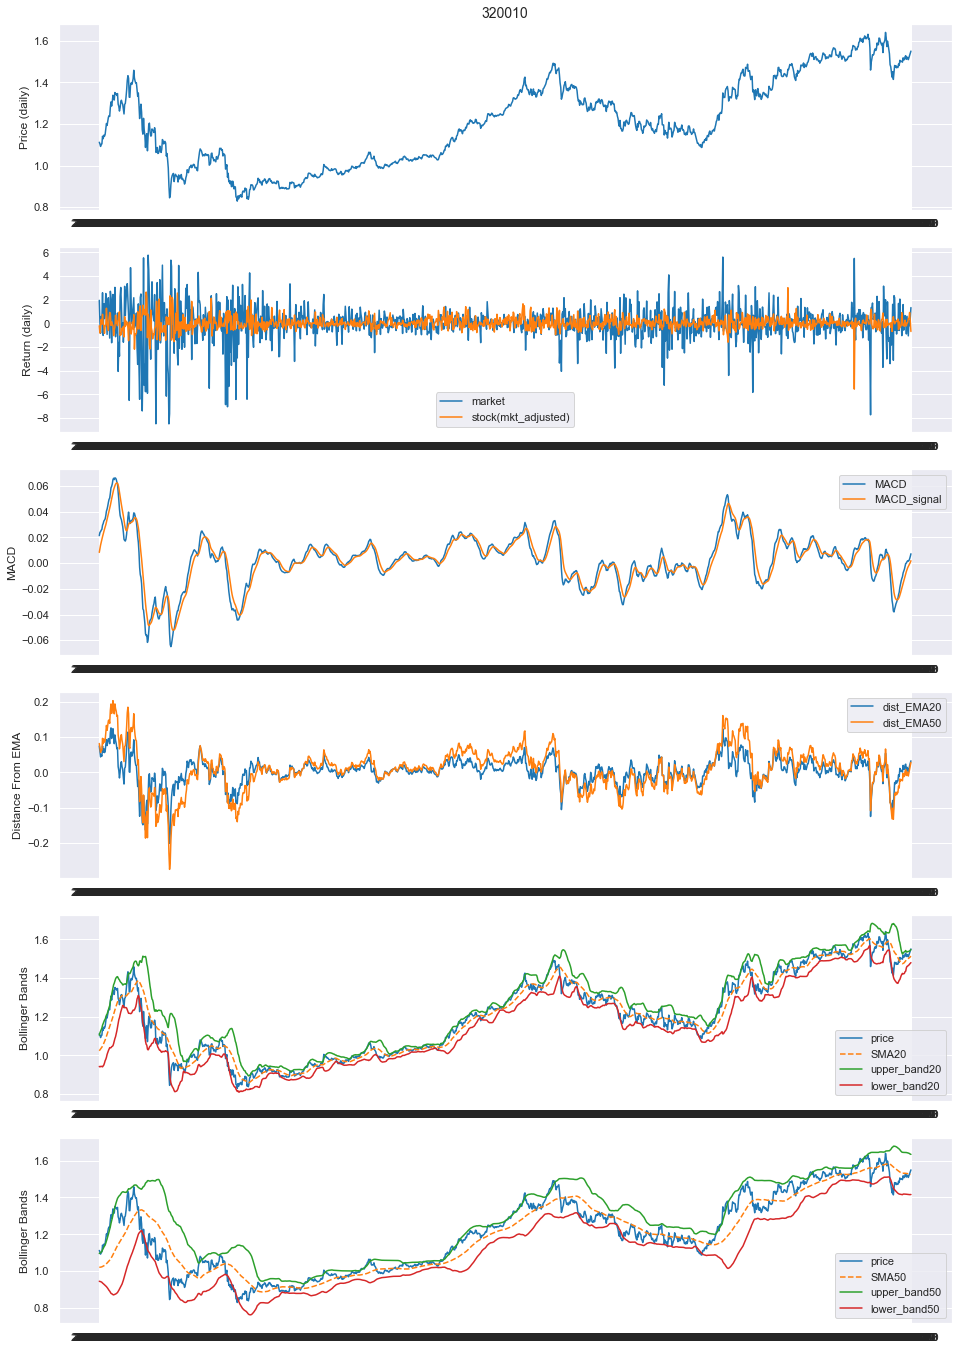

In [39]:
import csv
from pandas.core.frame import DataFrame
import pandas as pd
from ZFundPredictor import FundPredictor
 
funds = pd.read_csv('demo/funds_20200430.csv', index_col=0)

# print(df)

predictor = FundPredictor(funds)
randticker = predictor.get_randticker()
predictor.get_features(randticker, log_form=True, ma=[20,50], show_graph=True)

In [ ]:
categorical.loc[randticker]

fund_type                   混合型
fund_style                 大盘平衡
asset_size        (9.03, 19.83]
ranking_score       (0.75, 1.0]
current_stocks            0.867
current_bonds                 0
current_cash             0.1202
ind_0                    0.6701
ind_1                    0.0439
ind_2                    0.1271
ind_3                         0
ind_4                         0
ind_5                         0
ind_6                    0.0258
ind_7                         0
ind_8                         0
ind_9                         0
ind_10                        0
ind_11                        0
ind_12                        0
ind_13                        0
ind_14                        0
ind_15                        0
ind_16                        0
ind_17                        0
Name: 080012, dtype: object

_________________
<font size=3>It is interesting to discover that the market-adjusted return of this fund are inversely correlated to the return of index, although it is classified as a large-cap balanced hybrid fund. No wander it has been among the lowest in terms of manager ranking score, given the previous market spikes.<br>
Nevertheless, it might not be such a bad thing since the bull market is quite over now...</font>
_________________

c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 59ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 114ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 124ms/step
=============== 040008 / Model (50, 1) / 'ema' ===============
Train Size: (908, 50, 5) (240, 50, 5)
Test Size: (908, 1) (240, 1)
Size of Data for Future Prediction: (1, 50, 5)
Stopped at epoch: 21
Train Score: 0.00033 MSE (0.02 RMSE)
Test Score: 0.00104 MSE (0.03 RMSE)
R-Squared: -1.0403
Future Prediction: [3.2627]
=============== 040008 / Model (120, 2) / 'ema' ===============
Train Size: (781, 120, 5) (225, 120, 5)
Test Size: (781, 2) (225, 2)
Size of Data for Future Prediction: (1, 120, 5)
Stopped at epoch: 28
Train Score: 0.00086 MSE (0.03 RMSE)
Test Score: 0.00374 MSE (0.06 RMSE)
R-Squared: -7.9433
Future Prediction: [3.1585, 3.1527]
=============== 040008 / Model (120, 5) / 'ema' ===============
Train Size: (775, 120, 5) (225, 120, 5)
Test Size: (775, 5) (225, 5)
Size of Data for Future Prediction: (1, 120, 5)
Stopped at epoch: 17
Train Score: 0.00254 MSE (0.05 RMSE)
Test Score: 0.00753 MSE (0.09 RMSE)
R-Squared: -16.4463
Futu

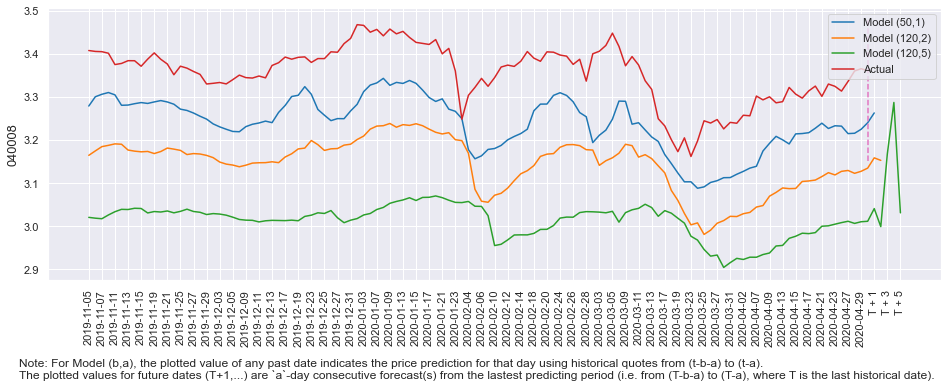

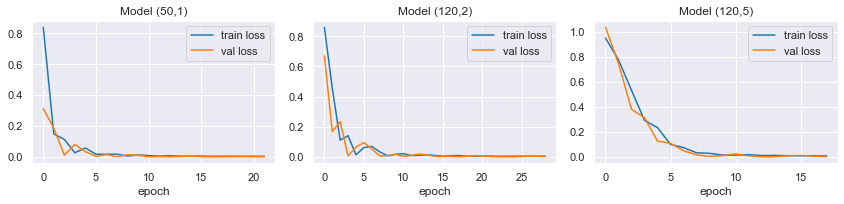

In [41]:
import csv
from pandas.core.frame import DataFrame
import pandas as pd
from ZFundPredictor import FundPredictor
 
funds = pd.read_csv('demo/funds_20200430.csv', index_col=0)

predictor = FundPredictor(funds)

callbacks = [keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-5, patience=5)]

params = {'ma':[20, 50],
          'epochs':90, 'batches':300, 'lr':0.0005,
          'windows':[[50, 1], [120, 2], [120, 5]],
          'indicators':'ema',
          'callbacks':callbacks,
          'show_history':True}
randticker = predictor.get_randticker()

single_prediction = predictor.get_prediction(randticker, **params)

c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 55ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 125ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 138ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 67ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 150ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 163ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 80ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 172ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 186ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 90ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 200ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 199ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 95ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 291ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 295ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 143ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 370ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 372ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 181ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 412ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 488ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 219ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 573ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 623ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 304ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 672ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 1s/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 428ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 921ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 688ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 268ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 590ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 586ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 291ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 686ms/step


c:\Users\NagisaZZ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 726ms/step
=============== 460001 / Model (50, 1) / 'ema' ===============
Train Size: (908, 50, 5) (240, 50, 5)
Test Size: (908, 1) (240, 1)
Size of Data for Future Prediction: (1, 50, 5)
Selected Hyperparameters: [{'ma': [5, 50], 'dropout': 0.3}]
R-Squared (ensemble): 0.7832
Future Prediction: [3.38]
=============== 460001 / Model (120, 2) / 'ema' ===============
Train Size: (781, 120, 5) (225, 120, 5)
Test Size: (781, 2) (225, 2)
Size of Data for Future Prediction: (1, 120, 5)
Selected Hyperparameters: [{'ma': [5, 50], 'dropout': 0.3}]
R-Squared (ensemble): 0.1527
Future Prediction: [3.4671, 3.3245]
=============== 460001 / Model (120, 5) / 'ema' ===============
Train Size: (775, 120, 5) (225, 120, 5)
Test Size: (775, 5) (225, 5)
Size of Data for Future Prediction: (1, 120, 5)
Selected Hyperparameters: [{'ma': [5, 50], 'dropout': 0.2}]
R-Squared (ensemble): 0.3598
Future Prediction: [3.3735, 3.4376, 3.3474, 3.3543, 3.2706]


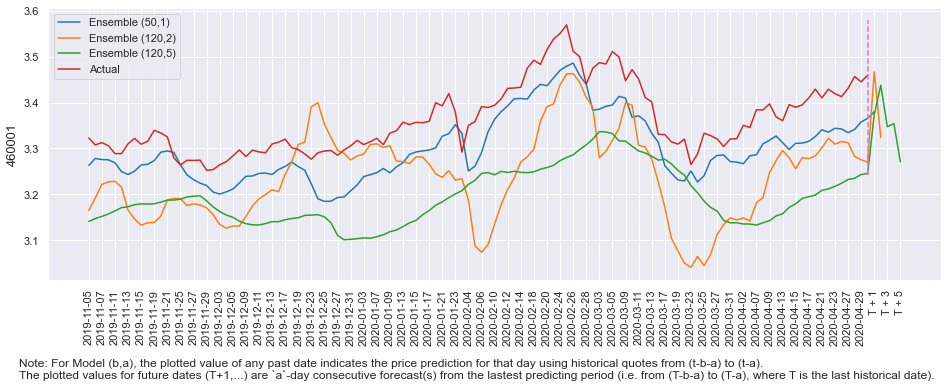

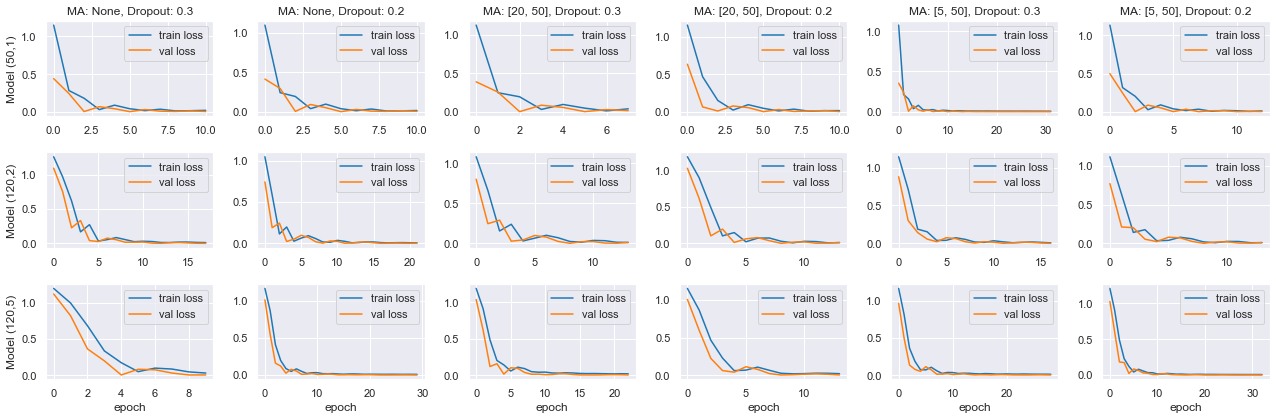

In [42]:
import csv
from pandas.core.frame import DataFrame
import pandas as pd
from ZFundPredictor import FundPredictor
 
funds = pd.read_csv('demo/funds_20200430.csv', index_col=0)

randticker = predictor.get_randticker()


predictor = FundPredictor(funds)

tune_params = {'ma_basket':[None, [20,50], [5,50]],
               'dropout_basket':[0.3, 0.2],
               'show_history':True,
               'pred_params':{'epochs':90, 'batches':300, 'lr':0.0005, 
                              'callbacks':callbacks,
                              'windows':[[50, 1], [120, 2], [120, 5]]}}

ensemble_prediction = predictor.ensemble_prediction(randticker, **tune_params)

_________________
<font size=3>It seems that for this particular fund, ***{'ma': None, 'dropout': 0.3}*** represents the best-performing hyperparameter combination. However, for numerous other funds, prediction accuracy may vary with different hyperparameter choices.</font>
_________________